### Import libraries

In [163]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)



/kaggle/input/breast-cancer-wisconsin-data/data.csv


### Import the [dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

In [164]:
filepath = "/kaggle/input/breast-cancer-wisconsin-data/data.csv"
df = pd.read_csv(filepath)

### Transform the label

In [165]:
df["diagnosis"] = df["diagnosis"].astype(str).str.lower().str.strip()
df["diagnosis"] = df["diagnosis"].map({"m":1, "b":0})
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Divide the dataset into train and test

In [151]:
from sklearn.model_selection import train_test_split
droplist = ["id","diagnosis","Unnamed: 32"]
X = df.drop(columns = droplist)
y = df["diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42) 

### Standardization of the features

In [152]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
standardized_X_train = scaler.transform(X_train)
standardized_X_test = scaler.transform(X_test)

### Use Grid-Search to find the optimal parameters

In [153]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
model = SVC(random_state = 42, probability = True)
param = {
    "C":[1,2,3,4,5,6,7,8,9,10,20],
    "gamma":['scale', 'auto', 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}
grid = GridSearchCV(model,param)
grid.fit(X_test,y_test)
best_params = grid.best_params_
best_score = grid.best_score_

Print the best parameters as well as the best score 

In [154]:
print(best_params)
print(best_score)

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.9644268774703557


### Training and prediction of the model with the best parameters

In [155]:
model = SVC(random_state = 42, probability = True, **best_params)
model.fit(X_train,y_train)
y_predproba=model.predict_proba(X_test)[:, 1]
y_pred=model.predict(X_test)

### Cross validation to evaluate the performance of the model

In [156]:
from sklearn.model_selection import cross_val_score
model = SVC(random_state = 42, probability = True, **best_params)
scores = cross_val_score(model, X_test, y_test,cv=10)
print(scores)

[0.91666667 1.         1.         0.91666667 1.         1.
 1.         1.         0.90909091 0.90909091]


### Evaluation of the model through further metrics

In [157]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Precision Score: " + str(precision_score(y_test, y_pred)))
print("Recall Score: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.956140350877193
Precision Score: 0.975
Recall Score: 0.9069767441860465
F1 Score: 0.9397590361445783


### Visualization of the confusion matrix

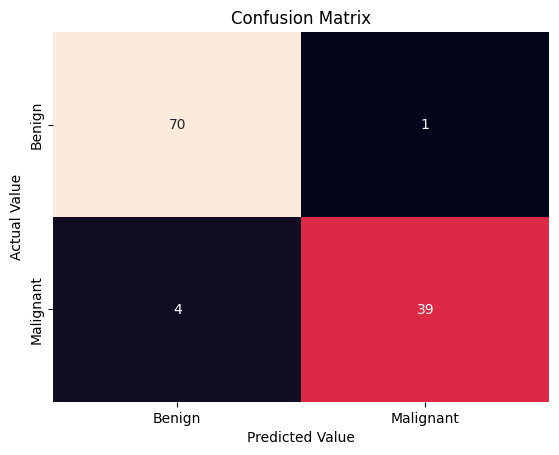

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred)

plt.figsize=(8,6)
sns.heatmap(cm, annot = True, cbar = False,linecolor= "black", xticklabels = ["Benign/0", "Malignant/1"] , yticklabels = ["Benign", "Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

### Visualization of the ROC curve

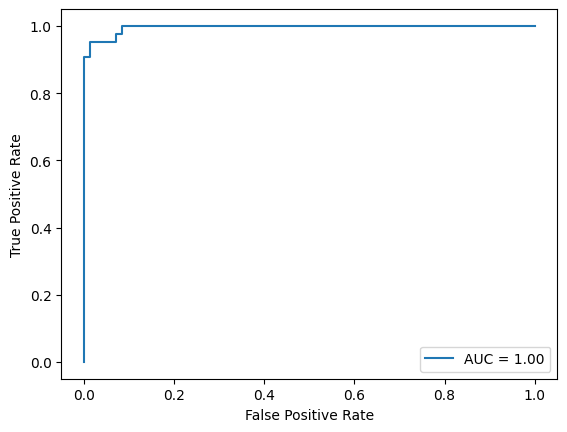

In [159]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
fpr, tpr, thresholds = roc_curve( y_test, y_predproba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

### Visualization of the learning curve of the model

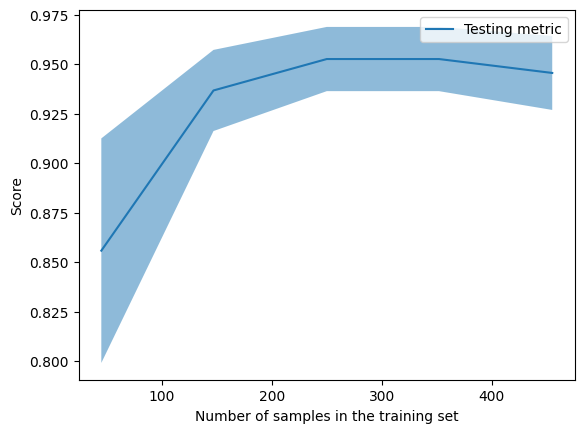

In [158]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, learning_curve
model = SVC(random_state = 42, probability = True, **best_params)
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y)
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()